# Initialization



In [1]:
!pip install tensorflow_recommenders

In [2]:
import numpy as np
import pandas as pd
import requests
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import tensorflow as tf
import tensorflow_recommenders as tfrs
from IPython.display import Markdown, display
from concurrent.futures import ThreadPoolExecutor

# Data Wrangling

In [3]:
urls = [
    "https://raw.githubusercontent.com/AldiraPutri19/Locoveer/refs/heads/machine-learning/datasets/user_ratings.csv",
    "https://raw.githubusercontent.com/AldiraPutri19/Locoveer/refs/heads/machine-learning/datasets/users.csv",
    "https://raw.githubusercontent.com/AldiraPutri19/Locoveer/refs/heads/machine-learning/datasets/travel_destinations.csv"
]

file_path = "/content/"
os.makedirs(file_path, exist_ok=True)

def download_data(url):
    """Download data from the URL and save it locally."""
    file_name = url.split("/")[-1]
    full_file_path = os.path.join(file_path, file_name)

    try:
        response = requests.get(url)
        response.raise_for_status()
        with open(full_file_path, "wb") as file:
            file.write(response.content)
            print(f"Successfully downloaded: {file_name}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {file_name} - Error: {e}")

with ThreadPoolExecutor() as executor:
    executor.map(download_data, urls)


Successfully downloaded: users.csv
Successfully downloaded: travel_destinations.csv
Successfully downloaded: user_ratings.csv


In [4]:
user_rating = pd.read_csv('user_ratings.csv')
user = pd.read_csv('users.csv')
travel_destination = pd.read_csv('travel_destinations.csv')

def printmd(string):
    display(Markdown(string))

printmd("Dataset user:")
print(user.head())
printmd("Dataset user_rating:")
print(user_rating.head())
printmd("Dataset travel_destination:")
print(travel_destination.head())

printmd("Number of Users: {:,}".format(len(user.User_ID.unique())))
printmd("Number of Travel Destinations: {:,}".format(len(travel_destination.Destination_ID.unique())))

Dataset user:

   User_ID             Name                          Email  Age  Gender  \
0        1     Tono Pratama     tonopratama858@example.com   34    Male   
1        2       Eka Kusuma       ekakusuma629@example.com   59    Male   
2        3   Lina Sari B.A.         linasari11@example.com   61  Female   
3        4  Bambang Hidayat  bambanghidayat565@example.com   26  Female   
4        5     Tono Santoso     tonosantoso978@example.com   49    Male   

                       Address  
0           Tegal, Jawa Tengah  
1  Kupang, Nusa Tenggara Timur  
2            Lhokseumawe, Aceh  
3        Semarang, Jawa Tengah  
4        Batam, Kepulauan Riau  


Dataset user_rating:

   User_ID  Destination_ID  Rating
0       50              70       5
1      540              71       5
2      602             315       4
3      622             120       4
4      863             268       5


Dataset travel_destination:

   Destination_ID                   Destination_Name  \
0             1.0                   Monumen Nasional   
1             2.0                           Kota Tua   
2             3.0                      Dunia Fantasi   
3             4.0  Taman Mini Indonesia Indah (TMII)   
4             5.0           Atlantis Water Adventure   

                                         Description       Category     City  \
0  Monumen Nasional atau yang populer disingkat d...         Budaya  Jakarta   
1  Kota tua di Jakarta, yang juga bernama Kota Tu...         Budaya  Jakarta   
2  Dunia Fantasi atau disebut juga Dufan adalah t...  Taman Hiburan  Jakarta   
3  Taman Mini Indonesia Indah merupakan suatu kaw...  Taman Hiburan  Jakarta   
4  Atlantis Water Adventure atau dikenal dengan A...  Taman Hiburan  Jakarta   

      Price                                       Coordinate       Lat  \
0   20000.0          {'lat': -6.1753924, 'lng': 106.8271528} -6.175392   
1       0.0  {'lat': -6.1376447999

Number of Users: 1,000

Number of Travel Destinations: 437

# Data Exploration & Visualization


In [5]:
printmd("**Missing Values:**")
print(user.isnull().sum(), '\n')
print(user_rating.isnull().sum(), '\n')
print(travel_destination.isnull().sum())

**Missing Values:**

User_ID    0
Name       0
Email      0
Age        0
Gender     0
Address    0
dtype: int64 

User_ID           0
Destination_ID    0
Rating            0
dtype: int64 

Destination_ID        0
Destination_Name      0
Description           0
Category              0
City                  0
Price                 0
Coordinate            0
Lat                   3
Long                  0
Unnamed: 11         437
Unnamed: 12           0
dtype: int64


In [6]:
travel_destination.drop(columns=['Coordinate','Lat','Long','Unnamed: 11', 'Unnamed: 12'], inplace=True)

In [7]:
travel_destination.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Destination_ID    437 non-null    float64
 1   Destination_Name  437 non-null    object 
 2   Description       437 non-null    object 
 3   Category          437 non-null    object 
 4   City              437 non-null    object 
 5   Price             437 non-null    float64
dtypes: float64(2), object(4)
memory usage: 20.6+ KB


In [8]:
rating_by_destination = user_rating.groupby("Destination_ID").agg({"User_ID": "count", "Rating": "mean"}).reset_index()
rating_by_destination.columns = ["Destination_ID", "Number of Ratings", "Average Rating"]

cutoff = 50
top_rated_destinations = rating_by_destination.loc[rating_by_destination["Number of Ratings"] > cutoff].sort_values(by="Average Rating", ascending=False)

printmd("Top Rated Travel Destinations:")
print(top_rated_destinations.head())

Top Rated Travel Destinations:

     Destination_ID  Number of Ratings  Average Rating
336             337                236        3.313559
132             133                251        3.274900
90               91                208        3.240385
292             293                235        3.217021
21               22                225        3.191111


# Preprocessing Data

In [9]:
cutoff_no_rat = 50
recent_ratings = user_rating.loc[user_rating["Destination_ID"].isin(top_rated_destinations["Destination_ID"])]
print("Number of Ratings after filter: {:,}".format(recent_ratings.shape[0]))

userIds = recent_ratings.User_ID.unique()
destinationIds = recent_ratings.Destination_ID.unique()

user_mapping = {id_: idx for idx, id_ in enumerate(userIds)}
destination_mapping = {id_: idx for idx, id_ in enumerate(destinationIds)}

user_rating['User_ID'] = user_rating['User_ID'].map(user_mapping)
user_rating['Destination_ID'] = user_rating['Destination_ID'].map(destination_mapping)

ratings = tf.data.Dataset.from_tensor_slices({
    "userId": tf.cast(recent_ratings.User_ID.values, tf.float32),
    "destinationId": tf.cast(recent_ratings.Destination_ID.values, tf.float32),
    "rating": tf.cast(recent_ratings.Rating.values, tf.int8),
})

total_ratings = len(recent_ratings)

shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train_size = int(total_ratings * 0.7)
val_size = int(total_ratings * 0.15)

train = shuffled.take(train_size)
validation = shuffled.skip(train_size).take(val_size)
test = shuffled.skip(train_size + val_size).take(total_ratings - train_size - val_size)

print("Training set size:", train_size)
print("Validation set size:", val_size)
print("Testing set size:", total_ratings - train_size - val_size)

unique_userIds = userIds
unique_destinationIds = destinationIds

Number of Ratings after filter: 100,000
Training set size: 70000
Validation set size: 15000
Testing set size: 15000


# Basic Model Training

In [10]:
# class RankingModel(tf.keras.Model):
#     def __init__(self):
#         super().__init__()
#         embedding_dimension = 32
#         self.user_embeddings = tf.keras.Sequential([
#             tf.keras.layers.experimental.preprocessing.StringLookup(
#                 vocabulary=[str(x) for x in unique_userIds], mask_token=None),
#             tf.keras.layers.Embedding(len(unique_userIds) + 1, embedding_dimension)
#         ])

#         self.destination_embeddings = tf.keras.Sequential([
#             tf.keras.layers.experimental.preprocessing.StringLookup(
#                 vocabulary=[str(x) for x in unique_destinationIds], mask_token=None),
#             tf.keras.layers.Embedding(len(unique_destinationIds) + 1, embedding_dimension)
#         ])

#         self.ratings = tf.keras.Sequential([
#             tf.keras.layers.Dense(256, activation="relu"),
#             tf.keras.layers.Dense(64, activation="relu"),
#             tf.keras.layers.Dense(1)
#         ])

#     def call(self, userId, destinationId):
#         user_embeddings = self.user_embeddings(tf.as_string(userId))
#         destination_embeddings = self.destination_embeddings(tf.as_string(destinationId))
#         return self.ratings(tf.concat([user_embeddings, destination_embeddings], axis=1))

# class travelRecommendationModel(tfrs.models.Model):
#     def __init__(self):
#         super().__init__()
#         self.ranking_model = RankingModel()
#         self.task = tfrs.tasks.Ranking(
#             loss=tf.keras.losses.MeanSquaredError(),
#             metrics=[tf.keras.metrics.RootMeanSquaredError()]
#         )

#     def compute_loss(self, features, training=False):
#         rating_predictions = self.ranking_model(features["userId"], features["destinationId"])
#         return self.task(labels=features["rating"], predictions=rating_predictions)

# model = travelRecommendationModel()
# model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

# cached_train = train.shuffle(100_000).batch(8192).cache()
# cached_test = test.batch(4096).cache()

# model.fit(cached_train, epochs=10)

In [11]:
class RankingModel(tf.keras.Model):
    def __init__(self, user_ids, destination_ids, embedding_dimension=128):
        super().__init__()
        self.user_embeddings = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=[str(x) for x in user_ids], mask_token=None),
            tf.keras.layers.Embedding(len(user_ids) + 1, embedding_dimension)
        ])
        self.destination_embeddings = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=[str(x) for x in destination_ids], mask_token=None),
            tf.keras.layers.Embedding(len(destination_ids) + 1, embedding_dimension)
        ])
        self.ratings = tf.keras.Sequential([
            tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(256, activation="relu"),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1)
        ])

    def call(self, userId, destinationId):
        user_embeddings = self.user_embeddings(tf.as_string(userId))
        destination_embeddings = self.destination_embeddings(tf.as_string(destinationId))
        return self.ratings(tf.concat([user_embeddings, destination_embeddings], axis=1))

class TravelRecommendationModel(tfrs.models.Model):
    def __init__(self, ranking_model):
        super().__init__()
        self.ranking_model = ranking_model
        self.task = tfrs.tasks.Ranking(
            loss=tf.keras.losses.Huber(),
            metrics=[tf.keras.metrics.RootMeanSquaredError()]
        )

    def call(self, inputs):
        user_id = inputs["userId"]
        destination_id = inputs["destinationId"]
        return self.ranking_model(user_id, destination_id)

    def compute_loss(self, features, training=False):
        rating_predictions = self.ranking_model(features["userId"], features["destinationId"])
        return self.task(labels=features["rating"], predictions=rating_predictions)

def train_model(model, train_data, validation_data, epochs=10, learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=500,
    decay_rate=0.75), callbacks=None):
    model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate))

    # Prepare training and validation data
    cached_train = train_data.shuffle(100_000).batch(2048).cache()
    cached_validation = validation_data.batch(1024).cache()

    if callbacks is None:
        callbacks = []

    history = model.fit(cached_train, validation_data=cached_validation, epochs=epochs, callbacks=callbacks)
    return history

def evaluate_model(model, test_data):
    cached_test = test_data.batch(1024).cache()
    return model.evaluate(cached_test, return_dict=True)

def generate_recommendations(model, user_id, destination_ids, user_mapping, travel_destination, top_n=5):
    test_rating = {}
    for m in destination_ids:
        test_rating[m] = model.ranking_model(tf.convert_to_tensor([user_id]), tf.convert_to_tensor([m]))

    top_destinations = sorted(test_rating, key=test_rating.get, reverse=True)[:top_n]
    recommendations = []
    for dest_id in top_destinations:
        dest_name = travel_destination[travel_destination["Destination_ID"] == dest_id]["Destination_Name"].iloc[0]
        recommendations.append(dest_name)
    return recommendations

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Example Usage
user_ids = recent_ratings.User_ID.unique()
destination_ids = recent_ratings.Destination_ID.unique()
ranking_model = RankingModel(user_ids, destination_ids)
travel_model = TravelRecommendationModel(ranking_model)

history = train_model(travel_model, train, validation, epochs=20, callbacks=[early_stopping])

Epoch 1/20
35/35 [==============================] - 8s 169ms/step - root_mean_squared_error: 2.1028 - loss: 1.2484 - regularization_loss: 2.1205 - total_loss: 3.3689 - val_root_mean_squared_error: 1.4083 - val_loss: 0.7696 - val_regularization_loss: 1.1527 - val_total_loss: 1.9223
Epoch 2/20
35/35 [==============================] - 5s 150ms/step - root_mean_squared_error: 1.4183 - loss: 0.8032 - regularization_loss: 0.6750 - total_loss: 1.4782 - val_root_mean_squared_error: 1.4115 - val_loss: 0.7726 - val_regularization_loss: 0.3455 - val_total_loss: 1.1181
Epoch 3/20
35/35 [==============================] - 6s 162ms/step - root_mean_squared_error: 1.4146 - loss: 0.8013 - regularization_loss: 0.2037 - total_loss: 1.0050 - val_root_mean_squared_error: 1.4104 - val_loss: 0.7718 - val_regularization_loss: 0.1077 - val_total_loss: 0.8795
Epoch 4/20
35/35 [==============================] - 5s 147ms/step - root_mean_squared_error: 1.4153 - loss: 0.8019 - regularization_loss: 0.0669 - total_l

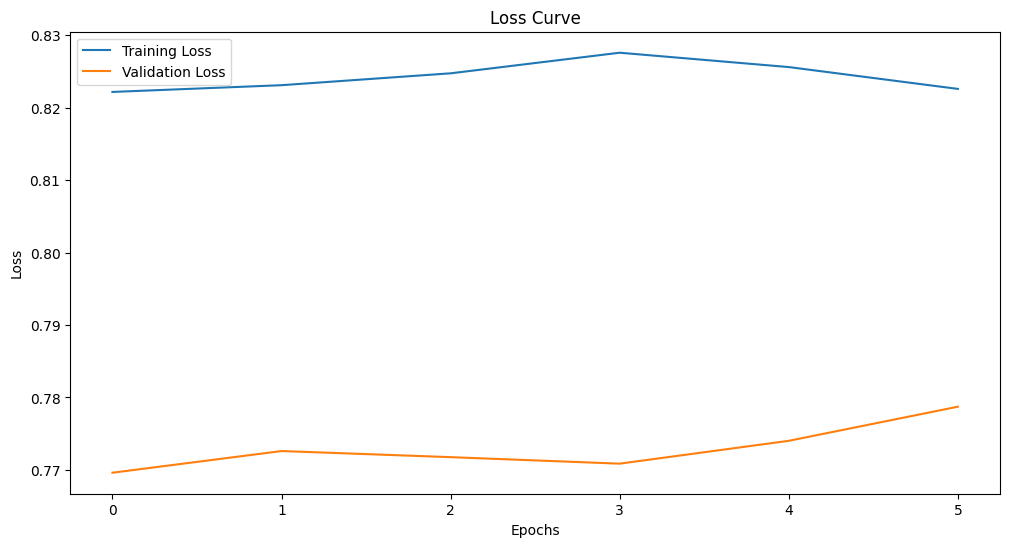

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

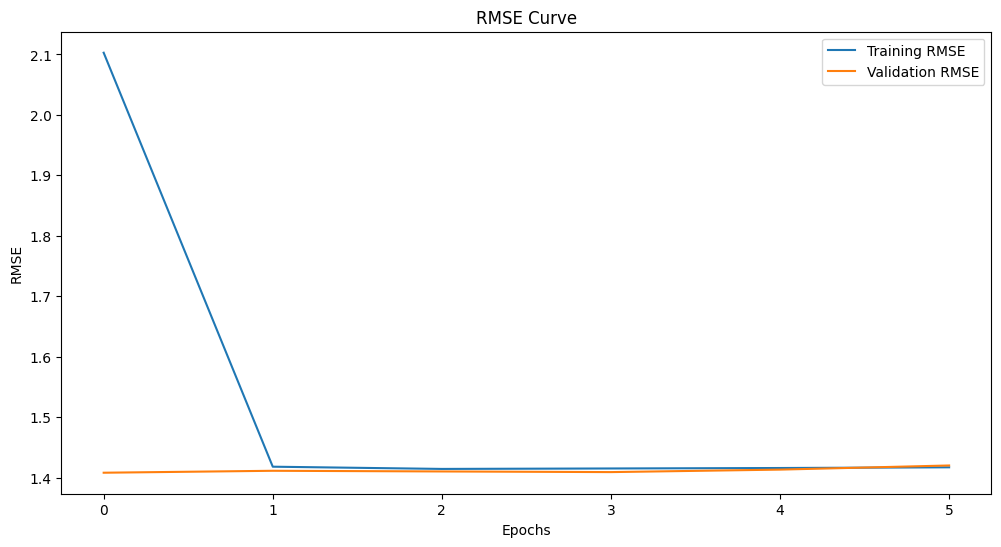

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('RMSE Curve')
plt.legend()
plt.show()

In [15]:
sample_user_id = tf.constant([1])
sample_destination_id = tf.constant([1])

_ = travel_model({"userId": sample_user_id, "destinationId": sample_destination_id})

travel_model.save('collaborative_filtering_recommendation_system', save_format='tf')

# Evaluation

In [16]:
evaluation_result = evaluate_model(travel_model, test)
print("Model evaluation result:", evaluation_result)

user_rand = userIds[123]
test_rating = {}

for m in test.take(5):
    test_rating[m["destinationId"].numpy()] = ranking_model(
        tf.convert_to_tensor([user_rand], dtype=tf.float32),
        tf.convert_to_tensor([m["destinationId"]], dtype=tf.float32)
    )

print("Top 5 recommended travel destinations for User {}: ".format(user_rand))
for m in sorted(test_rating, key=test_rating.get, reverse=True):
    dest_id = int(m)

    dest_name = travel_destination[travel_destination["Destination_ID"] == dest_id]["Destination_Name"].iloc[0]
    user_name = user[user["User_ID"] == user_rand]["Name"].iloc[0]

    print(f"User: {user_name}, Destination: {dest_name} (ID: {dest_id})")


15/15 [==============================] - 1s 34ms/step - root_mean_squared_error: 1.4218 - loss: 0.8048 - regularization_loss: 1.1527 - total_loss: 1.9575
Model evaluation result: {'root_mean_squared_error': 1.42177152633667, 'loss': 0.7734968662261963, 'regularization_loss': 1.1526538133621216, 'total_loss': 1.9261506795883179}
Top 5 recommended travel destinations for User 181: 
User: Sukmono Hidayat, Destination: GPIB Immanuel Semarang (Gereja Blenduk) (ID: 352)
User: Sukmono Hidayat, Destination: Bandros City Tour (ID: 330)
User: Sukmono Hidayat, Destination: Goa Pindul (ID: 178)
User: Sukmono Hidayat, Destination: Pantai Baron (ID: 157)
User: Sukmono Hidayat, Destination: Taman Lapangan Banteng (ID: 57)
